# Classifier 🤖

## Visualise Raw Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

label_to_name = {
    '1' : 'Mango',
    '7' : 'Pongamia Pinnata',
    '8' : 'Basil',
    '10' : 'Lemon'
}

In [2]:
df = pd.read_csv('plant_species_entropy/ilastik_skeletonize.csv')
df.head()

,Species,H0,H1
0,1,10.830617,6.032607
1,1,10.677257,5.852609
2,10,9.509690,3.142338
3,1,10.242452,5.737800
4,1,10.474478,5.778612


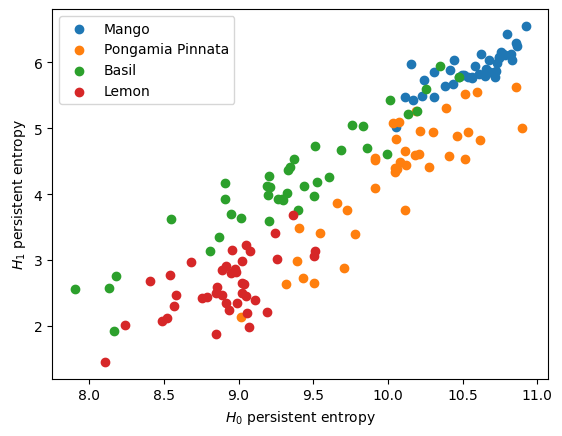

In [54]:
for species, pe in df.groupby(['Species']):
    plt.scatter(pe['H0'].tolist(), pe['H1'].tolist(), 
                label=label_to_name.get(str(species[0])))
plt.xlabel('$H_0$ persistent entropy')
plt.ylabel('$H_1$ persistent entropy')
# plt.title('Persistent entropy')
# plt.gca().set_aspect('equal')
plt.legend()
plt.savefig("plots/persistententropy.pdf", format="pdf")
plt.show()

## Find Optimal K using repeated k-fold CV

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm

In [5]:
X = df[['H0', 'H1']]
y = df['Species']

In [44]:
n_splits = 5
repetitions = 25

k_mean_cv_score_all = []

for repitition in tqdm(range(repetitions)):
    kfold = KFold(n_splits=n_splits, shuffle=True)
    k_mean_cv_score = []
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = [] 
        for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            knn.fit(X_train, y_train)
            scores.append(knn.score(X_test, y_test))
        k_mean_cv_score.append((k, np.mean(scores)))
    k_mean_cv_score_all.append(k_mean_cv_score)
    
k_mean_cv_score = np.mean(k_mean_cv_score_all, axis=0).tolist()
mean_cv_std = [y for (_, y) in np.std(k_mean_cv_score_all, axis=0)]

k_mean_cv_score.reverse()  # find largest index that yields maximum score
k_idx_max, max_accuracy = max(k_mean_cv_score, key=lambda item:item[1])
k_idx_max = int(k_idx_max)
print(f'Maximum (average of average) accuracy of {max_accuracy} given at k={k_idx_max}')

  0%|          | 0/25 [00:00<?, ?it/s]

Maximum (average of average) accuracy of 0.8132500000000001 given at k=4


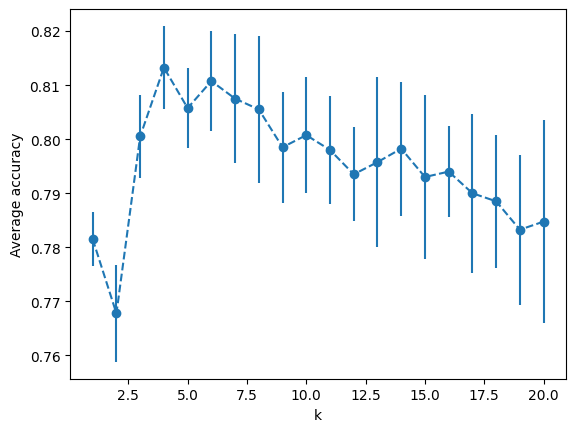

In [52]:
plt.errorbar(*zip(*k_mean_cv_score), mean_cv_std, marker='o', linestyle='--')
plt.xlabel('k')
plt.ylabel('Average accuracy')
# plt.title(f'Average repeated {n_splits}-fold cross validation and {repetitions} repititions')
plt.savefig("plots/cvscore.pdf", format="pdf")
plt.show()

In [47]:
knn = KNeighborsClassifier(n_neighbors=k_idx_max)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

## Visualise Decision Boundary

In [48]:
from matplotlib.colors import ListedColormap

In [49]:
h = 0.02  # step size in the mesh

buffer = 0.5
x_min, x_max = X.min()[0] - buffer, X.max()[0] + buffer 
y_min, y_max = X.min()[1] - buffer, X.max()[1] + buffer 

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

/Users/hemmingma/Documents/Python/mathbioproj/venv/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


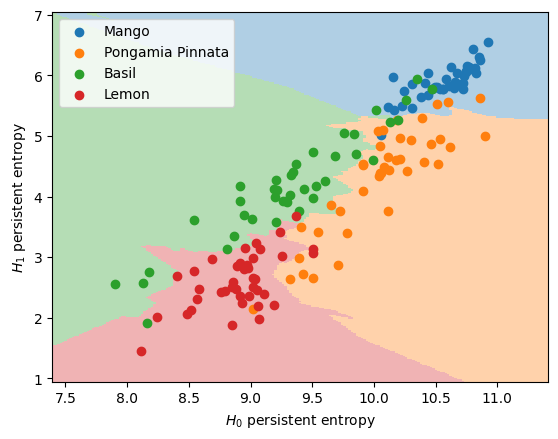

In [53]:
colors = ['tab:blue', 
          'tab:blue', # placeholders
          'tab:blue', 
          'tab:blue', 
          'tab:blue', 
          'tab:blue', 
          'tab:orange',
          'tab:green', 
          'tab:blue', 
          'tab:red']
cmap = ListedColormap(colors)

plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.35)

for species, pe in df.groupby(['Species']):
    plt.scatter(pe['H0'].tolist(), pe['H1'].tolist(), 
                label=label_to_name.get(str(species[0])))
plt.xlabel('$H_0$ persistent entropy')
plt.ylabel('$H_1$ persistent entropy')
plt.title(f'{k_idx_max}-NN decision boundary \n Mean accuracy={max_accuracy:.3f}')
# plt.gca().set_aspect('equal')
plt.legend()
plt.savefig("plots/decisionboundary.pdf", format="pdf")
plt.show()